# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [61]:
!pip install -U scikit-learn

     |████████████████████████████████| 7.2 MB 2.3 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1


In [62]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.impute import SimpleImputer

from sklearn.manifold import TSNE

from scipy import stats

import datetime

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [13]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

First 5 rows of both datasets, its shape and count of missing values in each datasets

In [14]:
#display(azdias.head())

In [15]:
#print(azdias.shape)

In [5]:
#display(customers.head())

In [6]:
#print(customers.shape)

In [7]:
#attribute_info.head()

In [8]:
#more_info.head()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [9]:
azdias = pd.read_csv('data/AZDIAS.csv', sep=',')
customers = pd.read_csv('data/CUSTOMER.csv', sep=',')
attribute_info = pd.read_excel('infos/DIAS Information Levels - Attributes 2017.xlsx',index_col=None, header=None ).drop(columns = 0, axis=1)
more_info = pd.read_excel('infos/DIAS Attributes - Values 2017.xlsx',index_col=None, header=None)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [16]:
#data cleaning
def str2float(x):
    if type(x)==str:
        return eval(x)
    else:
        return x

In [17]:
def data_cleaning(df):
    '''
    Replace strings 
    Replace missing values to np.nan - data taken from the excel provided.
    Replace na with mean
    LNR set as index
    Removal of outliers
    Cleaning columns if it doesn't have enough data
    '''
    print(df.shape)
        
    for column in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']:
        try:
            df[column] = df[column].replace(["X","XX"],np.nan)
        except:
            pass
        
    for column in ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
        df[column]=df[column].apply(str2float)
    
    #change the catergory columns into numbertraining
    for column in ["CAMEO_DEU_2015","D19_LETZTER_KAUF_BRANCHE","OST_WEST_KZ"]:
        df[column] = pd.Categorical(df[column])
        df[column] = df[column].cat.codes
        
    #extract the time,and keep the year   
    df["EINGEFUEGT_AM"]=pd.to_datetime(df["EINGEFUEGT_AM"]).dt.year
  
    temp_col = ["ALTERSKATEGORIE_GROB","ANREDE_KZ","GEBAEUDETYP","GEOSCORE_KLS7","HAUSHALTSSTRUKTUR",
            'HH_EINKOMMEN_SCORE',"KBA05_BAUMAX","KBA05_GBZ","KKK","NATIONALITAET_KZ","PRAEGENDE_JUGENDJAHRE",
            "REGIOTYP","TITEL_KZ","WOHNDAUER_2008","WACHSTUMSGEBIET_NB","W_KEIT_KIND_HH"]
    for column in temp_col:
        try:
            df[column] = df[column].replace([0,-1],np.nan)
        except:
            pass
        
    temp_col= ['KBA05_ALTER1','KBA05_ALTER2','KBA05_ALTER3','KBA05_ALTER4','KBA05_ANHANG','KBA05_AUTOQUOT',
             'KBA05_CCM1','KBA05_CCM2','KBA05_CCM3','KBA05_CCM4','KBA05_DIESEL','KBA05_FRAU','KBA05_HERST1',
             'KBA05_HERST2','KBA05_HERST3','KBA05_HERST4','KBA05_HERST5','KBA05_HERSTTEMP','KBA05_KRSAQUOT',
             'KBA05_KRSHERST1','KBA05_KRSHERST2','KBA05_KRSHERST3','KBA05_KRSKLEIN','KBA05_KRSOBER','KBA05_KRSVAN',
             'KBA05_KRSZUL','KBA05_KW1','KBA05_KW2','KBA05_KW3','KBA05_MAXAH','KBA05_MAXBJ','KBA05_MAXHERST',
             'KBA05_MAXSEG','KBA05_MAXVORB','KBA05_MOD1','KBA05_MOD2','KBA05_MOD3','KBA05_MOD4','KBA05_MOD8',
             'KBA05_MODTEMP','KBA05_MOTOR','KBA05_MOTRAD','KBA05_SEG1','KBA05_SEG10','KBA05_SEG2','KBA05_SEG3',
             'KBA05_SEG4','KBA05_SEG5','KBA05_SEG6','KBA05_SEG7','KBA05_SEG8','KBA05_SEG9','KBA05_VORB0',
             'KBA05_VORB1','KBA05_VORB2','KBA05_ZUL1','KBA05_ZUL2','KBA05_ZUL3','KBA05_ZUL4','RELAT_AB',
             'SEMIO_DOM',
             'SEMIO_ERL','SEMIO_FAM','SEMIO_KAEM','SEMIO_KRIT','SEMIO_KULT','SEMIO_LUST','SEMIO_MAT',
             'SEMIO_PFLICHT',
             'SEMIO_RAT','SEMIO_REL','SEMIO_SOZ','SEMIO_TRADV','SEMIO_VERT','ZABEOTYP']
    for column in temp_col:
        try:
            df[column] = df[column].replace([9,-1],np.nan)
        except:
            pass

    for column in df.columns.values:
        try:
            df[column] = df[column].replace([-1],np.nan)
        except:
            pass
        
    df['GEBURTSJAHR'] = df["GEBURTSJAHR"].replace([0],np.nan)

    #get rid of the rows which have the age is 0 which corresponds to NaN
    df = df.drop(['Unnamed: 0'],axis = 1)
    
    corr_matrix = df.corr().abs()
    limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
    drop_col = [column for column in limit.columns if any(limit[column] > 0.7)]
    df = df.drop(drop_col,axis =1)
    
    df = df.set_index('LNR')
    
    df_columns = list(df.columns.values)
    
    imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df, columns = df_columns)
    print(df.shape)
    
    return df

In [12]:
%%time
customers_cleaned = data_cleaning(customers)

(191652, 370)
(191652, 262)
CPU times: user 2min 50s, sys: 15.1 s, total: 3min 5s
Wall time: 3min 6s


In [13]:
# Check out unique values of ordinal features
display(["{}: {}".format(col_name, customers_cleaned[col_name].unique()) for col_name in customers_cleaned.columns])

['AGER_TYP: [2.0 1.0 0.0 3.0]',
 'AKT_DAT_KL: [1.0 9.0 3.0 7.0 5.0 2.0 4.0 6.0 8.0]',
 'ALTER_HH: [10.0 11.0 6.0 8.0 20.0 5.0 14.0 21.0 15.0 17.0 0.0 19.0 9.0 12.0 13.0\n 18.0 7.0 16.0 4.0 2.0 3.0]',
 'ALTER_KIND1: [18.0 8.0 12.0 9.0 7.0 13.0 17.0 14.0 11.0 16.0 6.0 10.0 15.0 5.0 3.0 4.0\n 2.0]',
 'ALTERSKATEGORIE_FEIN: [10.0 0.0 8.0 14.0 9.0 4.0 13.0 6.0 12.0 19.0 17.0 15.0 11.0 16.0 7.0 18.0\n 21.0 25.0 20.0 24.0 5.0 2.0 22.0 3.0 23.0]',
 'ANZ_HAUSHALTE_AKTIV: [1.0 0.0 7.0 74.0 9.0 17.0 12.0 29.0 2.0 45.0 10.0 14.0 15.0 55.0 6.0 5.0\n 108.0 3.0 25.0 18.0 4.0 11.0 19.0 8.0 26.0 43.0 63.0 47.0 16.0 31.0 57.0\n 37.0 13.0 22.0 20.0 23.0 27.0 305.0 52.0 21.0 34.0 46.0 24.0 33.0 51.0\n 523.0 104.0 101.0 59.0 44.0 38.0 61.0 69.0 28.0 48.0 40.0 39.0 145.0\n 107.0 32.0 76.0 117.0 87.0 84.0 41.0 286.0 92.0 222.0 119.0 71.0 36.0\n 344.0 42.0 82.0 160.0 35.0 67.0 30.0 112.0 85.0 93.0 58.0 60.0 221.0 77.0\n 102.0 140.0 79.0 53.0 290.0 243.0 105.0 75.0 50.0 70.0 54.0 165.0 86.0\n 156.0 277.0 95.0 

In [14]:
print(customers_cleaned.head())

  AGER_TYP AKT_DAT_KL ALTER_HH ALTER_KIND1 ALTERSKATEGORIE_FEIN  \
0        2          1       10          18                   10   
1        2          9       11          18                   10   
2        2          1        6          18                    0   
3        1          1        8          18                    8   
4        2          1       20          18                   14   

  ANZ_HAUSHALTE_AKTIV ANZ_HH_TITEL ANZ_KINDER ANZ_PERSONEN ANZ_TITEL  ... VHA  \
0                   1            0          0            2         0  ...   0   
1                   1            0          0            3         0  ...   0   
2                   1            0          0            1         0  ...   0   
3                   0            0          0            0         0  ...   0   
4                   7            0          0            4         0  ...   0   

  VHN VK_DHT4A W_KEIT_KIND_HH WOHNDAUER_2008 WOHNLAGE ZABEOTYP  \
0   3        5              6              9

In [15]:
%%time
azdias_cleaned = data_cleaning(azdias)

(891221, 367)
(891221, 254)
CPU times: user 6min 19s, sys: 35.7 s, total: 6min 54s
Wall time: 7min 8s


In [16]:
print(azdias_cleaned.head())

   AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTERSKATEGORIE_FEIN  \
0       2.0         1.0       0.0         18.0                  15.0   
1       2.0         9.0       0.0         18.0                  21.0   
2       2.0         9.0      17.0         18.0                  17.0   
3       2.0         1.0      13.0         18.0                  13.0   
4       2.0         1.0      20.0         18.0                  14.0   

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_TITEL  \
0                  1.0           0.0         0.0           1.0        0.0   
1                 11.0           0.0         0.0           2.0        0.0   
2                 10.0           0.0         0.0           1.0        0.0   
3                  1.0           0.0         0.0           0.0        0.0   
4                  3.0           0.0         0.0           4.0        0.0   

   ...  UMFELD_ALT  UMFELD_JUNG  UNGLEICHENN_FLAG  VERDICHTUNGSRAUM  VERS_TYP  \
0  ...         4.0     

In [17]:
# Check out unique values of ordinal features
display(["{}: {}".format(col_name, azdias_cleaned[col_name].unique()) for col_name in azdias_cleaned.columns])

['AGER_TYP: [2. 3. 0. 1.]',
 'AKT_DAT_KL: [1. 9. 5. 8. 7. 6. 4. 3. 2.]',
 'ALTER_HH: [ 0. 17. 13. 20. 10. 14. 16. 21. 11. 19. 15.  9. 18.  8.  7. 12.  4.  3.\n  6.  5.  2.  1.]',
 'ALTER_KIND1: [18. 17. 10. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]',
 'ALTERSKATEGORIE_FEIN: [15. 21. 17. 13. 14. 10. 16. 20. 11. 19. 18.  9. 22. 12.  0.  8.  7. 23.\n  4. 24.  6.  3.  2.  5. 25.  1.]',
 'ANZ_HAUSHALTE_AKTIV: [  1.  11.  10.   3.   5.   4.   6.   2.   9.   0.  14.  13.   8.   7.\n  44.  25.  36.  16. 272.  33.  15.  12.  22.  21.  20.  67.  23.  18.\n  27.  24.  31.  39.  19.  30.  17.  29.  61.  54.  88.  49.  60.  38.\n  34.  48.  35.  62.  26.  45.  42.  28.  77.  47.  50. 236. 137.  43.\n  52.  41.  76.  63.  32.  40.  37.  59.  53.  57. 118.  66.  95.  78.\n  70.  46. 185.  73. 154.  80. 102.  92. 126.  94.  71.  68.  81.  69.\n 121. 258.  58.  86. 124.  85.  90. 128.  51.  72.  64.  56.  83. 150.\n 259.  91. 160. 134. 169. 246.  82. 114. 183. 116.  74. 143.  99. 216.\n 

In [18]:
#Difference between customer and azdias dataset
diff = np.setdiff1d(customers_cleaned.columns, azdias_cleaned.columns)
customers_cleaned.drop(columns=diff, inplace=True, axis = 1)

In [19]:
diff = np.setdiff1d(azdias_cleaned.columns, customers_cleaned.columns)
azdias_cleaned.drop(columns=diff, inplace=True, axis = 1)

In [20]:
scaler = StandardScaler()

In [21]:
customers_cleaned.shape

(191652, 246)

In [22]:
azdias_cleaned.shape

(891221, 246)

In [23]:
import scipy
def remove_outliers(df):
    z_score = stats.zscore(df,axis =1)
    print(z_score)
    abs_z_score = np.abs(z_score)
    filtered_entries = (abs_z_score < 6).all(axis =1)
    new_df = df[filtered_entries]
    return new_df

In [24]:
#azdias = remove_outliers(azdias)
#customers = remove_outliers(customers)

In [25]:
customers_cleaned=pd.DataFrame(scaler.fit_transform(customers_cleaned.astype(float)),columns=customers_cleaned.columns)
azdias_cleaned=pd.DataFrame(scaler.fit_transform(azdias_cleaned.astype(float)),columns=azdias_cleaned.columns)

In [26]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(azdias_cleaned)

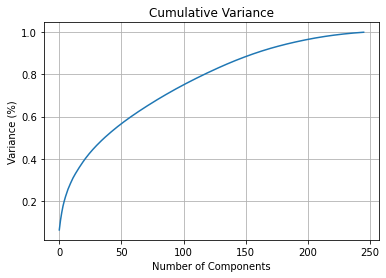

In [27]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Cumulative Variance')
plt.grid()
plt.show()

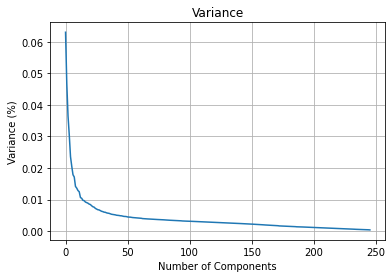

In [28]:
#Plotting the Variance
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Variance')
plt.grid()
plt.show()

In [29]:
azdias_cleaned['real_class']= 0
customers_cleaned['real_class'] = 1

#merge two dataset together
merge_data=pd.concat([azdias_cleaned, customers_cleaned])

In [31]:
pca = PCA().fit(azdias_cleaned)
azdiaz_pca = pca.transform(azdias_cleaned)
pca = PCA().fit(customers_cleaned)
customers_pca = pca.transform(customers_cleaned)

In [32]:
del customers
del azdias

In [33]:
#K-Means Clustering

def clustering(df,center):
    print(center) #for monitoring purpose
    kmeans = KMeans(center)
    model = kmeans.fit(df)
    score = np.abs(model.score(df))
    return score

In [34]:
%%time
pca_scores = []
centeriods = [2,5,8,9,11,13,15,17]

for center in centeriods:
    pca_scores.append(clustering(azdias_cleaned,center))

10
11
12
13
14
15
16
17
18
19
CPU times: user 3h 28min 37s, sys: 3min 8s, total: 3h 31min 45s
Wall time: 1h 8min 11s


In [35]:
print(pd.DataFrame(sorted(zip(centeriods, pca_scores),key = lambda x:x[1]), columns = ['centeroids','score']))

   centeroids         score
0          19  2.224757e+08
1          18  2.232564e+08
2          17  2.240371e+08
3          16  2.247883e+08
4          15  2.257058e+08
5          14  2.266378e+08
6          13  2.275830e+08
7          12  2.285258e+08
8          11  2.296271e+08
9          10  2.308057e+08


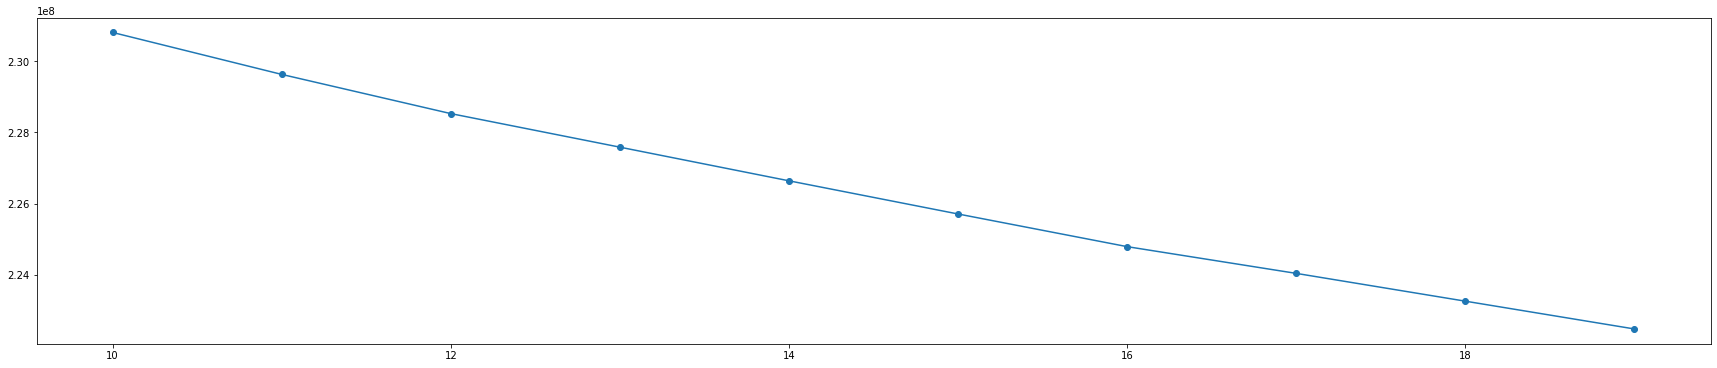

In [36]:
plt.figure(figsize=(30,6))
plt.plot(centeriods,pca_scores,marker='o')

In [ ]:
kmeans = KMeans(10,random_state=123)
pop_cluster = kmeans.fit_predict(azdias_pca)
cus_cluster = kmeans.predict(customers_pca)

## Final Conclusion

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1], title = 'General Population V/S Customer Distribution')
sns.distplot(cus, label = "Customer",ax=ax)
sns.distplot(azd, label = "General Population",ax=ax)
ax.legend()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [59]:
!pip install xgboost

ERROR: Could not find a version that satisfies the requirement plot_learning_curve (from versions: none)
ERROR: No matching distribution found for plot_learning_curve


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import sklearn

#from xgboost import XGBClassifier

#import warnings

In [36]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [37]:
mailout_train = pd.read_csv('data/mailout_train.csv', sep=',')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [38]:
X = mailout_train.drop('RESPONSE',axis =1)
y = mailout_train['RESPONSE']

In [39]:
mailout_train_cleaned = data_cleaning(mailout_train)

(42962, 368)
(42962, 259)


In [40]:
print(mailout_train_cleaned.shape)
print(y.shape)

(42962, 259)
(42962,)


In [ ]:
#mailout_train_cleaned.head(5), y.head(5)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.
    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.
    title : str
        Title for the chart.
    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.
    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.
    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.
    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).
    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    train_sizes : array-like of shape (n_ticks,), dtype={int, float}
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [49]:
#initialise 
#classifier_1_XGB = XGBClassifier(objective = 'binary:logistic',random_state= 123)
classifier_2_RF = RandomForestClassifier(random_state=123)
classifier_3_Ada = AdaBoostClassifier(random_state=123)
classifier_4_DT = DecisionTreeClassifier(random_state=123)

In [50]:
import sklearn
#test train split
#X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(mailout_train_cleaned,y,test_size =0.3, random_state =123)

In [58]:
cv = StratifiedKFold(n_splits=4)

<Figure size 720x720 with 0 Axes>

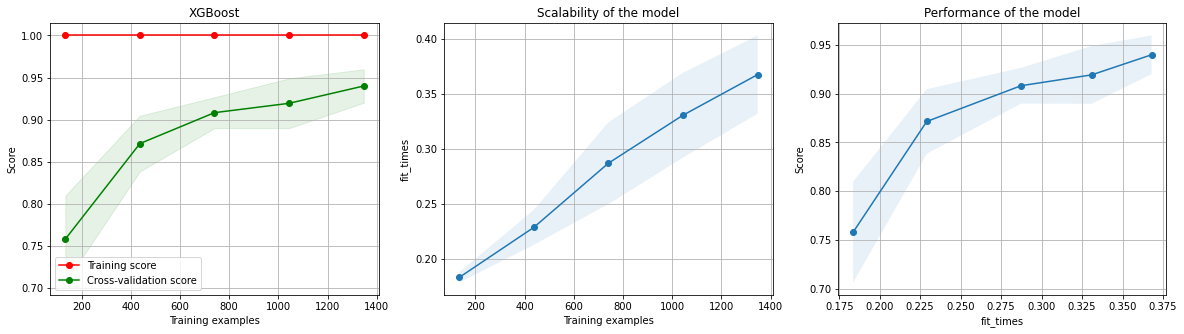

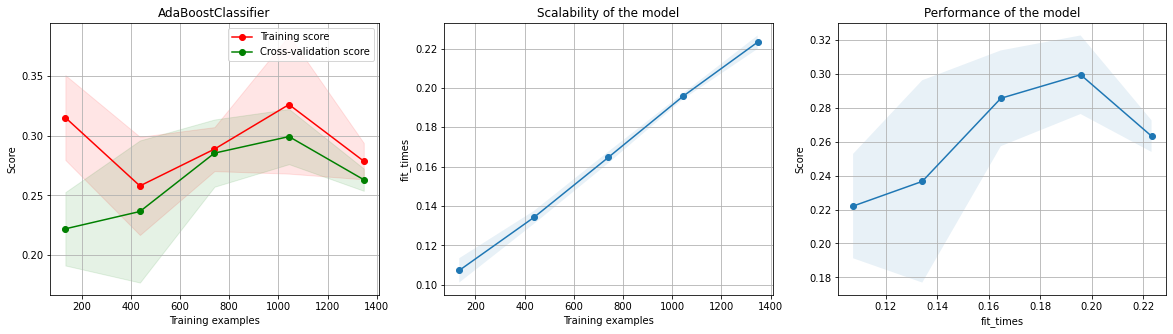

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

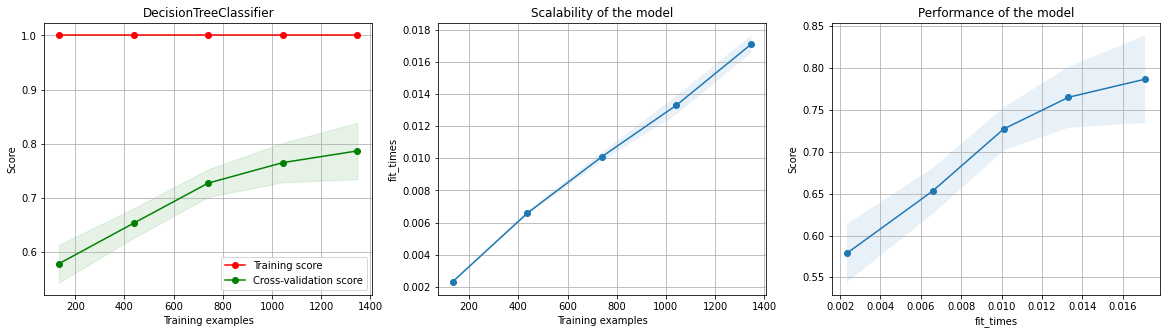

In [60]:
plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)
#plot_learning_curve(classifier_1_XGB,"XGBoost",X_train.values,y_train.values,cv=cv,ylim(0.4,1),n_jobs =2)
plt.show()
plot_learning_curve(classifier_2_RF,"XGBoost",X,y,cv=cv,ylim=None,n_jobs =2)
plt.show()
plot_learning_curve(classifier_3_Ada,"AdaBoostClassifier",X,y,cv=cv,ylim=None,n_jobs =2)
plt.show()
plot_learning_curve(classifier_4_DT,"DecisionTreeClassifier",X,y,cv=cv,ylim=None,n_jobs =2)



## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test = pd.read_csv('data/mailout_test.csv', sep=',')